## Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.ndimage import convolve

## Model

In [3]:
def spatiotemporal_diffusion_ode(t, y, grid_shape, dx, diffusion_rate, removal_rate, infectious_positions, generation_rates):
    """
    Defines the system of ODEs for the spatiotemporal diffusion model.

    Parameters:
        t (float): Current time (not used explicitly, as the system is autonomous).
        y (numpy.ndarray): Flattened 1D array of the grid's quanta concentrations.
        grid_shape (tuple): Shape of the grid (rows, cols).
        dx (float): Grid spacing (assumed dx = dy).
        diffusion_rate (float): Diffusion rate (in m^2/s).
        removal_rate (float): Removal rate (in s^-1).
        infectious_positions (list): List of (x, y) positions of infectious people in the grid.
        generation_rates (list): List of quanta generation rates (in quanta per second).

    Returns:
        numpy.ndarray: Flattened 1D array of the time derivatives of the grid's quanta concentrations.
    """
    # Reshape the 1D array back into a 2D grid
    grid = y.reshape(grid_shape)
    rows, cols = grid_shape

    # Initialize the time derivative of the grid
    dgrid_dt = np.zeros_like(grid)

    # Diffusion coefficient
    alpha = diffusion_rate / (dx**2)

    # Apply the 5-point stencil for diffusion
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            dgrid_dt[i, j] = alpha * (
                grid[i - 1, j] + grid[i + 1, j] + grid[i, j - 1] + grid[i, j + 1] - 4 * grid[i, j]
            )

    # Add removal term
    dgrid_dt -= removal_rate * grid

    # Add quanta generation at infectious positions
    for (x, y), rate in zip(infectious_positions, generation_rates):
        dgrid_dt[x, y] += rate

    # Flatten the 2D array back into a 1D array
    return dgrid_dt.flatten()

def solve_diffusion(grid, dx, diffusion_rate, removal_rate, infectious_positions, generation_rates, t_span, dt):
    """
    Solves the spatiotemporal diffusion model using an ODE solver.

    Parameters:
        grid (numpy.ndarray): 2D array representing the initial quanta concentration.
        dx (float): Grid spacing (assumed dx = dy).
        diffusion_rate (float): Diffusion rate (in m^2/s).
        removal_rate (float): Removal rate (in s^-1).
        infectious_positions (list): List of (x, y) positions of infectious people in the grid.
        generation_rates (list): List of quanta generation rates (in quanta per second).
        t_span (tuple): Time span for the simulation (start, end) in seconds.
        dt (float): Time step for the solver output.

    Returns:
        tuple: (times, results), where `times` is an array of time points and `results` is a 3D array of quanta concentrations over time.
    """
    # Flatten the initial grid into a 1D array
    y0 = grid.flatten()

    # Time points for the solver
    t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

    # Solve the ODE system
    sol = solve_ivp(
        spatiotemporal_diffusion_ode,
        t_span,
        y0,
        t_eval=t_eval,
        args=(grid.shape, dx, diffusion_rate, removal_rate, infectious_positions, generation_rates),
        method='LSODA'  # Similar to lsodes in R
    )

    # Reshape the solution back into a 3D array (time, rows, cols)
    results = sol.y.T.reshape(-1, grid.shape[0], grid.shape[1])

    return sol.t, results

## Simulation

### Data

In [4]:
# Room grid (20m x 10m, 0.5m cell size)
room_length = 20
room_width = 10
cell_size = 0.5

rows = int(room_width / cell_size)
cols = int(room_length / cell_size)

# Grid for concentration values
grid = np.zeros((rows, cols))

# Infectious positions and generation rates
infectious_positions = [(int(2 / cell_size), int(5 / cell_size)), (int(5 / cell_size), int(15 / cell_size))]
generation_rates = [1 / 3600, 10 / 3600]  # quanta per second

# Diffusion rate
aer = 10  # air exchange rate in 1/h
aer = aer / 3600  # convert to 1/s
diffusion_rate = (0.52 * aer + 8.61e-5) * (1286**(2/3))  # m^2/s

# Removal rate 
settling = 1 / 3600
inactivation = 1 / 3600
removal_rate = aer + settling + inactivation # quanta per second

### Run the model

In [5]:
# Solve the diffusion model for the first period (8am to 9am)
t_span_1 = (0, 3600)  # 8am to 9am
times_1, results_1 = solve_diffusion(
    grid, cell_size, diffusion_rate, removal_rate, infectious_positions, generation_rates, t_span_1, 1
)

# Use the grid from 9am as the initial condition for the second period (9am to 10am)
grid_9am = results_1[-1]  # Last grid state from the first period
t_span_2 = (3600, 7200)  # 9am to 10am
times_2, results_2 = solve_diffusion(
    grid_9am, cell_size, diffusion_rate, removal_rate, [], [], t_span_2, 1
)

# Combine the results from both periods
times = np.concatenate((times_1, times_2))
results = np.concatenate((results_1, results_2))

### Results

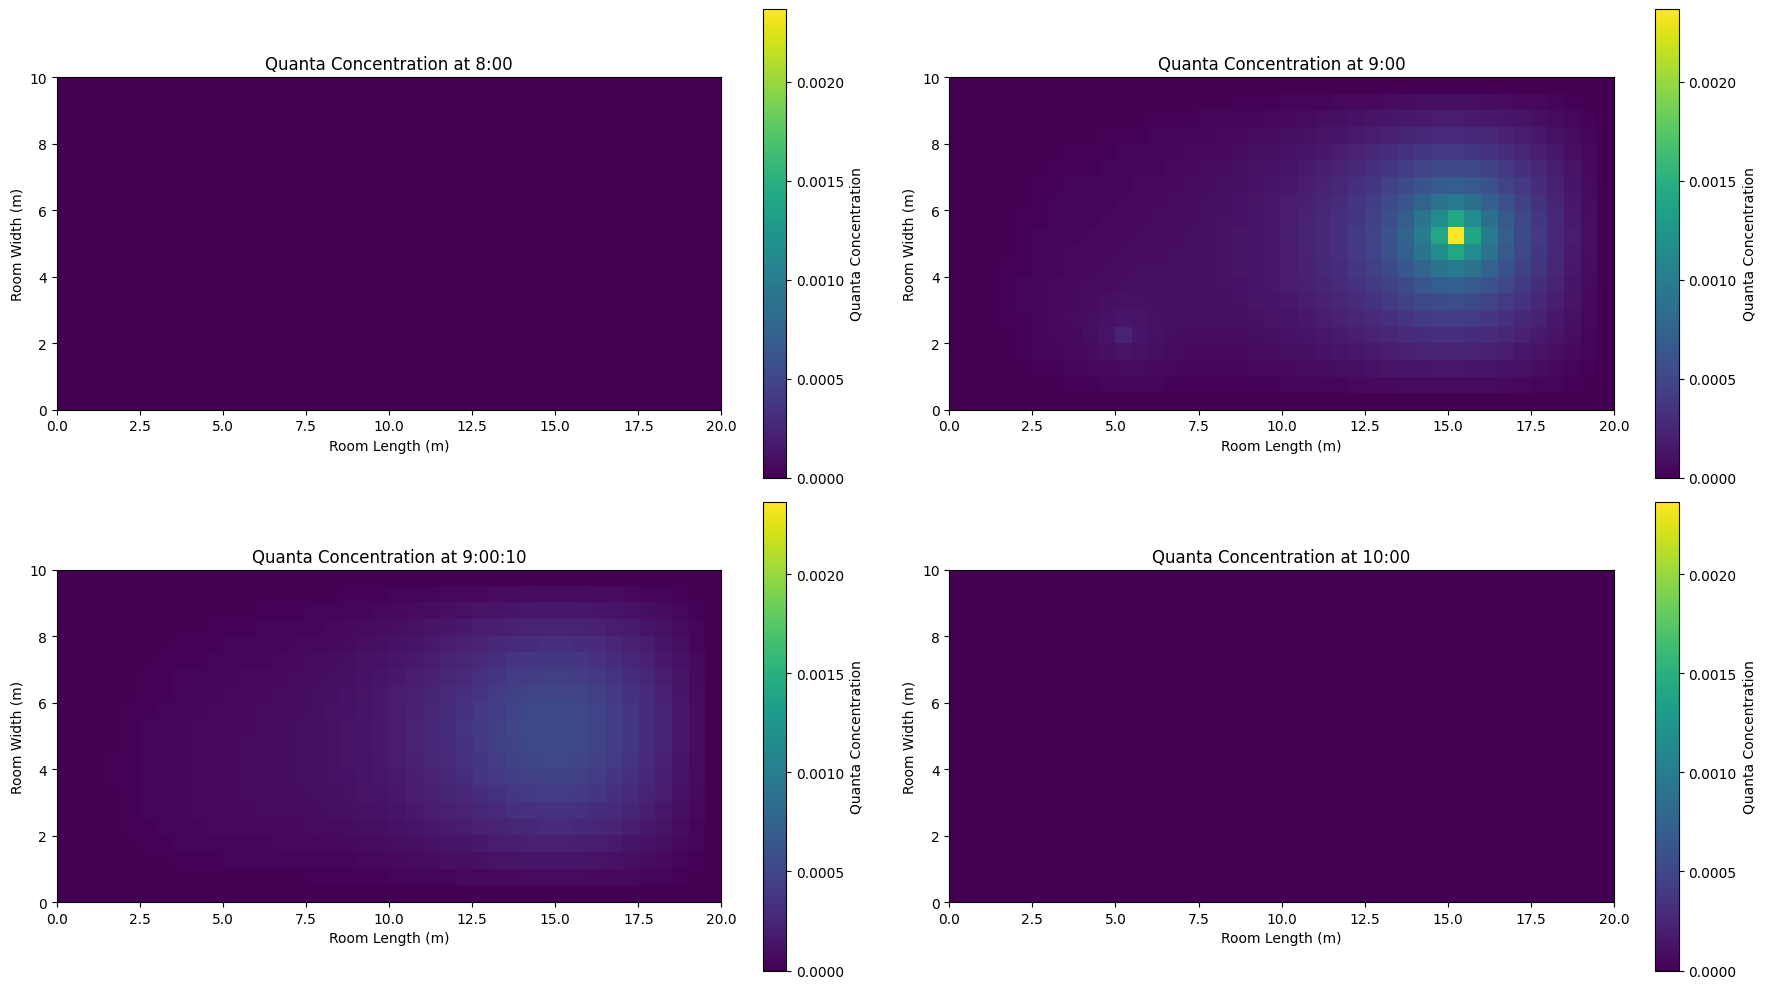

In [6]:
# Calculate global min and max for consistent colorbar range
global_min = results.min()
global_max = results.max()

# Plot the results at specified times
time_labels = ["8:00", "9:00", "9:00:10", "10:00"]
time_indices = [0, 3600, 3610, 7200]  # Corresponding times in seconds

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

for ax, time_label, time_index in zip(axes, time_labels, time_indices):
	# Find the closest time index in the results
	idx = np.where(times == time_index)[0][0]
	grid_snapshot = results[idx]
	
	im = ax.imshow(grid_snapshot, origin='lower', extent=[0, room_length, 0, room_width], 
				   cmap='viridis', vmin=global_min, vmax=global_max)
	ax.set_title(f"Quanta Concentration at {time_label}")
	ax.set_xlabel("Room Length (m)")
	ax.set_ylabel("Room Width (m)")
	fig.colorbar(im, ax=ax, orientation='vertical', label="Quanta Concentration")

plt.tight_layout()
plt.show()

## With masked areas

### Model

In [7]:
def spatiotemporal_diffusion_ode2(t, y, grid_shape, dx, diffusion_rate, removal_rate, infectious_positions, generation_rates, mask):
    grid = y.reshape(grid_shape)
    
    # Diffusion coefficient
    alpha = diffusion_rate / dx**2

    # Define 5-point stencil kernel
    kernel = np.array([[0, 1, 0],
                       [1, -4, 1],
                       [0, 1, 0]])

    # Apply convolution only where mask is True
    diffused = convolve(grid * mask, kernel, mode='constant', cval=0.0)

    # Compute change, apply mask to keep outside values zero
    dgrid_dt = alpha * diffused
    dgrid_dt -= removal_rate * grid
    dgrid_dt *= mask  # Zero out outside domain

    # Add quanta generation
    for (x, y), rate in zip(infectious_positions, generation_rates):
        if mask[x, y]:
            dgrid_dt[x, y] += rate

    return dgrid_dt.flatten()

def solve_diffusion2(grid, dx, diffusion_rate, removal_rate, infectious_positions, generation_rates, t_span, dt, mask):
    y0 = grid.flatten()
    t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

    sol = solve_ivp(
        spatiotemporal_diffusion_ode2,
        t_span,
        y0,
        t_eval=t_eval,
        args=(grid.shape, dx, diffusion_rate, removal_rate, infectious_positions, generation_rates, mask),
        method='LSODA'
    )

    results = sol.y.T.reshape(-1, grid.shape[0], grid.shape[1])
    return sol.t, results


### Data

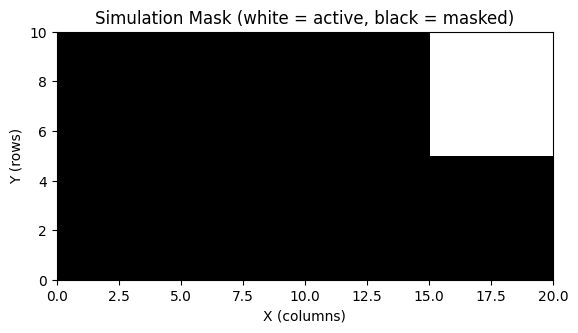

In [ ]:
# Initialize full mask as True (entire grid is valid)
mask = np.ones_like(grid, dtype=bool)

# Mask bottom-right corner (2.5m x 2.5m) = 5 cells x 5 cells
corner_size = int(5 / cell_size)  # = 5

# Bottom-right corner starts from (rows - 5, cols - 5)
mask[rows - corner_size:, cols - corner_size:] = False

import matplotlib.pyplot as plt

plt.imshow(mask, origin='lower', extent=[0, room_length, 0, room_width], cmap="gray_r")
plt.title("Simulation Mask (black = active, white = masked)")
plt.xlabel("X (columns)")
plt.ylabel("Y (rows)")
plt.show()

### Rund the model

In [26]:
# Solve the diffusion model for the first period (8am to 9am)
t_span_3 = (0, 600)  # 8am to 8:10am
times_3, results_3 = solve_diffusion2(
    grid, cell_size, diffusion_rate, removal_rate, [(int(10),int(29))], [10/3600], t_span_3, 1, mask
)

### Results

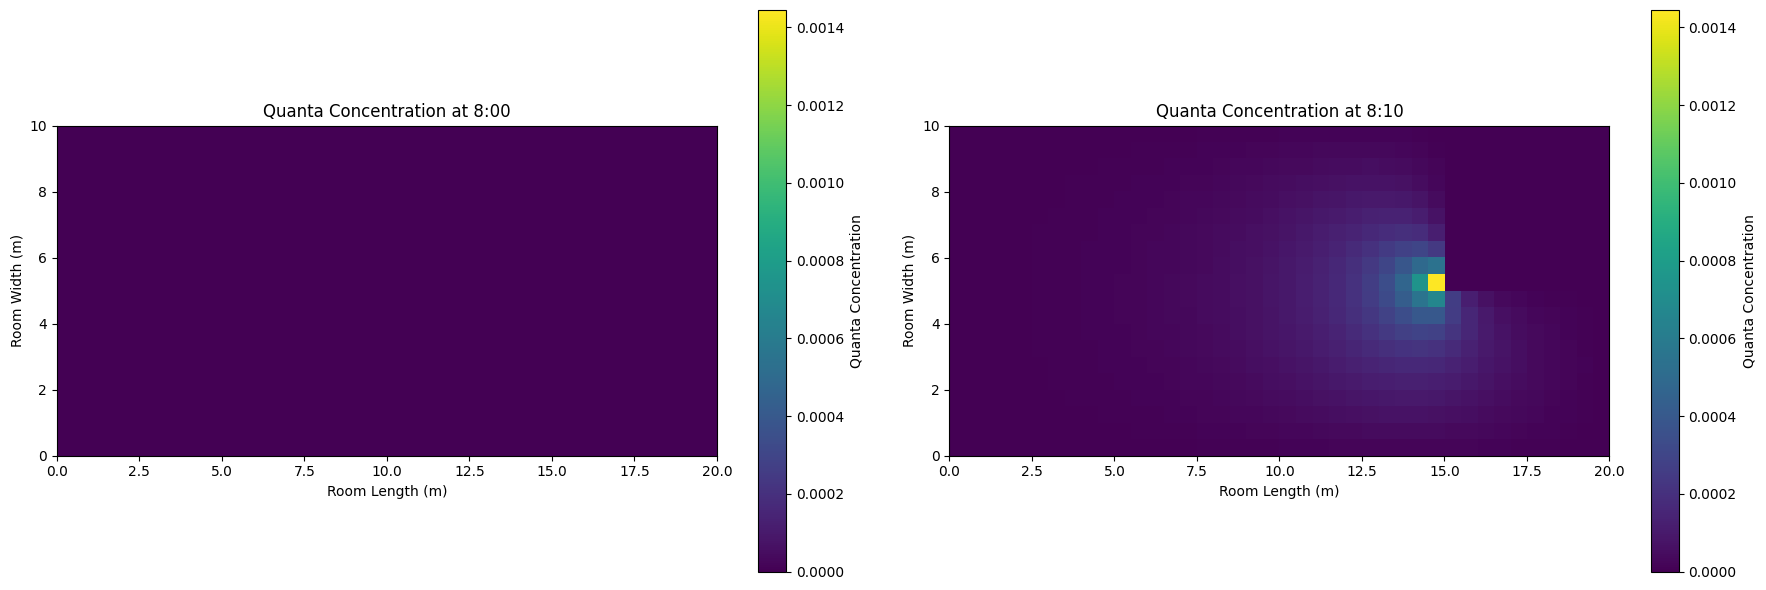

In [27]:
# Calculate global min and max for consistent colorbar range
global_min = results_3.min()
global_max = results_3.max()

# Plot the results at specified times
time_labels = ["8:00", "8:10"]
time_indices = [0, 600]  # Corresponding times in seconds

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes = axes.flatten()

for ax, time_label, time_index in zip(axes, time_labels, time_indices):
	# Find the closest time index in the results
	idx = np.where(times_3 == time_index)[0][0]
	grid_snapshot = results_3[idx]
	
	im = ax.imshow(grid_snapshot, origin='lower', extent=[0, room_length, 0, room_width], 
				   cmap='viridis', vmin=global_min, vmax=global_max)
	ax.set_title(f"Quanta Concentration at {time_label}")
	ax.set_xlabel("Room Length (m)")
	ax.set_ylabel("Room Width (m)")
	fig.colorbar(im, ax=ax, orientation='vertical', label="Quanta Concentration")

plt.tight_layout()
plt.show()

In [37]:
results_3[600,10:20,35:40]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [41]:
mask[:,35:40]

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])